# CNN Explaination

[作業說明投影片](https://docs.google.com/presentation/d/1VClvgyilAvohextY0tM3gD7YemXGSUrzLV0E8RjDnMU/edit?usp=sharing)

如果有自己的計算資源，不想使用 colab 的話，可以參考純 [Python script](https://github.com/leo19941227/MLHW4-Explainable) 的版本

## Environment settings

In [ ]:
# 下載並解壓縮訓練資料
!gdown --id '19CzXudqN58R3D-1G8KeFWk8UDQwlb8is' --output food-11.zip
!unzip food-11.zip

In [ ]:
# 安裝lime套件
# 這份作業會用到的套件大部分 colab 都有安裝了，只有 lime 需要額外安裝
!pip install lime==0.1.1.37

## Start our python script

In [49]:
import os
import sys
import argparse
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from skimage.segmentation import slic
from lime import lime_image
from pdb import set_trace
import time
import random

# 固定隨機種子
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(0)

In [4]:
path_prefix = ""
pic_name = [path_prefix + str(i)+'.jpg' for i in range (30)] # 設定一個裝 30 張 jpg 的 list
pic_cnt = 0
#plt.savefig(pic_name[pic_cnt])

In [5]:
batch_size = 128
drop_rate = 0.5

## Model definition and checkpoint loading

In [6]:
# best_model
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.cnn = nn.Sequential(
        # class torch.nn.Sequential(*args)

            nn.Conv2d(3, 64, 5, 1, 2),  # [64, 128, 128] ps.padding 後從 128 => 132，再從 132-5+1 = 128
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, 3, 1, 1),  # [128, 128, 128] ps.padding 後從 128 => 130，再從 130-3+1 = 128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),        # [128, 64, 64] 128/2 = 64

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32] ps.padding 後從 64 => 66，再從 66-3+1 = 64
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),        # [256, 32, 32] 64/2 = 32

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 32, 32] ps.padding 後從 32 => 34，再從 34-3+1 = 32
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),        # [512, 32, 32] 32/2 = 16
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 16, 16] ps.padding 後從 16 => 18，再從 18-3+1 = 16
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),        # [512, 4, 4] 16/2= 8

            ############################多加層數#################################
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 4, 4] ps.padding 後從 8 => 10，再從 10-3+1 = 8
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 2, 2] 8/2= 4

            nn.Conv2d(512, 512, 3, 1, 1), # [512, 4, 4] ps.padding 後從 4 => 6，再從 6-3+1 = 4
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0)        # [512, 2, 2] 4/2= 2
        )
        self.fc = nn.Sequential(
            # flatten
            nn.Linear(512*2*2, 1024),
            torch.nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(1024, 512),
            torch.nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.reshape(out.size()[0], -1)
        return self.fc(out)     

In [ ]:
# 下載模型
!gdown --id '1NwLeZ3wBHx-SgCxRqiNsLEaDGiLwsV_l' --output model.pkl
model_best = Classifier().cuda()
model_best.load_state_dict(torch.load('model.pkl'))
# 基本上出現 <All keys matched successfully> 就是有載入成功，但最好還是做一下 inference 確認 test accuracy 沒有錯。

In [8]:
# 確認參數量
model_best.eval()
from torchsummary import summary
summary(model_best, input_size=(3, 128, 128))  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           4,864
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4        [-1, 128, 128, 128]          73,856
       BatchNorm2d-5        [-1, 128, 128, 128]             256
              ReLU-6        [-1, 128, 128, 128]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 256, 64, 64]         295,168
       BatchNorm2d-9          [-1, 256, 64, 64]             512
             ReLU-10          [-1, 256, 64, 64]               0
        MaxPool2d-11          [-1, 256, 32, 32]               0
           Conv2d-12          [-1, 512, 32, 32]       1,180,160
      BatchNorm2d-13          [-1, 512, 32, 32]           1,024
             ReLU-14          [-1, 512,

## Argument parsing

In [9]:
args = {
      'ckptpath': './checkpoint.pth',
      'dataset_dir': './food-11/'
}
args = argparse.Namespace(**args)

## Dataset definition and creation

In [10]:
# 助教 training 時定義的 dataset
# 因為 training 的時候助教有使用底下那些 transforms，所以 testing 時也要讓 test data 使用同樣的 transform
# dataset 這部分的 code 基本上不應該出現在你的作業裡，你應該使用自己當初 train HW3 時的 preprocessing
class FoodDataset(Dataset):
    def __init__(self, paths, labels, mode):
        # mode: 'train' or 'eval'
        
        self.paths = paths
        self.labels = labels
        trainTransform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
        ])
        evalTransform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.ToTensor(),
        ])
        self.transform = trainTransform if mode == 'train' else evalTransform

    # 這個 FoodDataset 繼承了 pytorch 的 Dataset class
    # 而 __len__ 和 __getitem__ 是定義一個 pytorch dataset 時一定要 implement 的兩個 methods
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        X = Image.open(self.paths[index])
        X = self.transform(X)
        Y = self.labels[index]
        return X, Y

    # 這個 method 並不是 pytorch dataset 必要，只是方便未來我們想要指定「取哪幾張圖片」出來當作一個 batch 來 visualize
    def getbatch(self, indices):
        images = []
        labels = []
        for index in indices:
            image, label = self.__getitem__(index)
            images.append(image)
            labels.append(label)
        return torch.stack(images), torch.tensor(labels)

# 給予 data 的路徑，回傳每一張圖片的「路徑」和「class」
def get_paths_labels(path):
    imgnames = os.listdir(path)
    imgnames.sort()
    imgpaths = []
    labels = []
    for name in imgnames:
        imgpaths.append(os.path.join(path, name))
        labels.append(int(name.split('_')[0]))
    return imgpaths, labels

In [11]:
train_paths, train_labels = get_paths_labels(os.path.join(args.dataset_dir, 'training'))

# 這邊在 initialize dataset 時只丟「路徑」和「class」，之後要從 dataset 取資料時
# dataset 的 __getitem__ method 才會動態的去 load 每個路徑對應的圖片
train_set = FoodDataset(train_paths, train_labels, mode='eval')

## Start Homework 5

### Saliency map

我們把一張圖片丟進 model，forward 後與 label 計算出 loss。
因此與 loss 相關的有:
- image
- model parameter
- label

通常的情況下，我們想要改變 model parameter 來 fit image 和 label。因此 loss 在計算 backward 時我們只在乎 **loss 對 model parameter** 的偏微分值。但數學上 image 本身也是 continuous tensor，我們可以計算  **loss 對 image** 的偏微分值。這個偏微分值代表「在 model parameter 和 label 都固定下，稍微改變 image 的某個 pixel value 會對 loss 產生什麼變化」。人們習慣把這個變化的劇烈程度解讀成該 pixel 的重要性 (每個 pixel 都有自己的偏微分值)。因此把同一張圖中，loss 對每個 pixel 的偏微分值畫出來，就可以看出該圖中哪些位置是 model 在判斷時的重要依據。

實作上非常簡單，過去我們都是 forward 後算出 loss，然後進行 backward。而這個 backward，pytorch 預設是計算 **loss 對 model parameter** 的偏微分值，因此我們只需要用一行 code 額外告知 pytorch，**image** 也是要算偏微分的對象之一。

In [12]:
def normalize(image):
    return (image - image.min()) / (image.max() - image.min())

def compute_saliency_maps(x, y, model):
    model.eval()
    x = x.cuda()

    # 最關鍵的一行 code
    # 因為我們要計算 loss 對 input image 的微分，原本 input x 只是一個 tensor，預設不需要 gradient
    # 這邊我們明確的告知 pytorch 這個 input x 需要gradient，這樣我們執行 backward 後 x.grad 才會有微分的值
    x.requires_grad_()
    
    y_pred = model(x)
    loss_func = torch.nn.CrossEntropyLoss()
    loss = loss_func(y_pred, y.cuda())
    loss.backward()

    saliencies = x.grad.abs().detach().cpu()
    # saliencies: (batches, channels, height, weight)
    # 因為接下來我們要對每張圖片畫 saliency map，每張圖片的 gradient scale 很可能有巨大落差
    # 可能第一張圖片的 gradient 在 100 ~ 1000，但第二張圖片的 gradient 在 0.001 ~ 0.0001
    # 如果我們用同樣的色階去畫每一張 saliency 的話，第一張可能就全部都很亮，第二張就全部都很暗，
    # 如此就看不到有意義的結果，我們想看的是「單一張 saliency 內部的大小關係」，
    # 所以這邊我們要對每張 saliency 各自做 normalize。手法有很多種，這邊只採用最簡單的
    saliencies = torch.stack([normalize(item) for item in saliencies])
    return saliencies

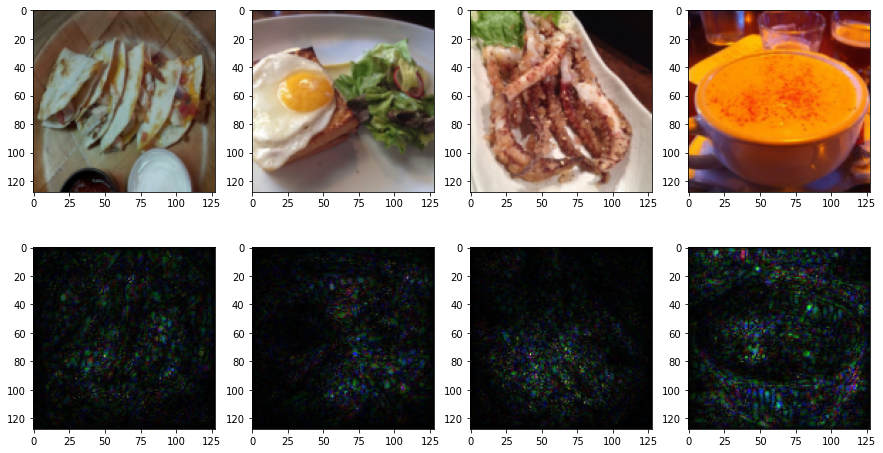

In [13]:
# img_indices = [2658,7889,31,7333,6444]
img_indices = [83, 4218, 4707, 8598]
images, labels = train_set.getbatch(img_indices)
saliencies = compute_saliency_maps(images, labels, model_best)

# 使用 matplotlib 畫出來

fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for row, target in enumerate([images, saliencies]):
    for column, img in enumerate(target):
        axs[row][column].imshow(img.permute(1, 2, 0).numpy())
        # 小知識：permute 是什麼，為什麼這邊要用?
        # 在 pytorch 的世界，image tensor 各 dimension 的意義通常為 (channels, height, width)
        # 但在 matplolib 的世界，想要把一個 tensor 畫出來，形狀必須為 (height, width, channels)
        # 因此 permute 是一個 pytorch 很方便的工具來做 dimension 間的轉換
        # 這邊 img.permute(1, 2, 0)，代表轉換後的 tensor，其
        # - 第 0 個 dimension 為原本 img 的第 1 個 dimension，也就是 height
        # - 第 1 個 dimension 為原本 img 的第 2 個 dimension，也就是 width
        # - 第 2 個 dimension 為原本 img 的第 0 個 dimension，也就是 channels

plt.savefig(pic_name[pic_cnt])
pic_cnt += 1
plt.show()
plt.close()
# 從第二張圖片的 saliency，我們可以發現 model 有認出蛋黃的位置
# 從第三、四張圖片的 saliency，雖然不知道 model 細部用食物的哪個位置判斷，但可以發現 model 找出了食物的大致輪廓

## Filter explaination

這裡我們想要知道某一個 filter 到底認出了什麼。我們會做以下兩件事情：
- Filter activation: 挑幾張圖片出來，看看圖片中哪些位置會 activate 該 filter
- Filter visualization: 怎樣的 image 可以最大程度的 activate 該 filter

實作上比較困難的地方是，通常我們是直接把 image 丟進 model，一路 forward 到底。如：
```
loss = model(image)
loss.backward()
```
我們要怎麼得到中間某層 CNN 的 output? 當然我們可以直接修改 model definition，讓 forward 不只 return loss，也 return activation map。但這樣的寫法麻煩了，更改了 forward 的 output 可能會讓其他部分的 code 要跟著改動。因此 pytorch 提供了方便的 solution: **hook**，以下我們會再介紹。

In [ ]:
def normalize(image):
  return (image - image.min()) / (image.max() - image.min())

layer_activations = None
def filter_explaination(x, model, cnnid, filterid, iteration=100, lr=1):
    # x: 要用來觀察哪些位置可以 activate 被指定 filter 的圖片們
    # cnnid, filterid: 想要指定第幾層 cnn 中第幾個 filter
    model.eval()

    def hook(model, input, output):
        global layer_activations
        layer_activations = output
  
    hook_handle = model.cnn[cnnid].register_forward_hook(hook)
    # 這一行是在告訴 pytorch，當 forward 「過了」第 cnnid 層 cnn 後，要先呼叫 hook 這個我們定義的 function 後才可以繼續 forward 下一層 cnn
    # 因此上面的 hook function 中，我們就會把該層的 output，也就是 activation map 記錄下來，這樣 forward 完整個 model 後我們就不只有 loss
    # 也有某層 cnn 的 activation map
    # 注意：到這行為止，都還沒有發生任何 forward。我們只是先告訴 pytorch 等下真的要 forward 時該多做什麼事
    # 注意：hook_handle 可以先跳過不用懂，等下看到後面就有說明了

    # Filter activation: 我們先觀察 x 經過被指定 filter 的 activation map
    model(x.cuda())
    # 這行才是正式執行 forward，因為我們只在意 activation map，所以這邊不需要把 loss 存起來
    filter_activations = layer_activations[:, filterid, :, :].detach().cpu()
    
    # 根據 function argument 指定的 filterid 把特定 filter 的 activation map 取出來
    # 因為目前這個 activation map 我們只是要把他畫出來，所以可以直接 detach from graph 並存成 cpu tensor
    
    # Filter visualization: 接著我們要找出可以最大程度 activate 該 filter 的圖片
    x = x.cuda()
    # 從一張 random noise 的圖片開始找 (也可以從一張 dataset image 開始找)
    x.requires_grad_()
    # 我們要對 input image 算偏微分
    optimizer = Adam([x], lr=lr)
    # 利用偏微分和 optimizer，逐步修改 input image 來讓 filter activation 越來越大
    for iter in range(iteration):
        optimizer.zero_grad()
        model(x)
        
        objective = -layer_activations[:, filterid, :, :].sum()
        # 與上一個作業不同的是，我們並不想知道 image 的微量變化會怎樣影響 final loss
        # 我們想知道的是，image 的微量變化會怎樣影響 activation 的程度
        # 因此 objective 是 filter activation 的加總，然後加負號代表我們想要做 maximization
        
        objective.backward()
        # 計算 filter activation 對 input image 的偏微分
        optimizer.step()
        # 修改 input image 來最大化 filter activation
    filter_visualization = x.detach().cpu().squeeze()[0]
    # 完成圖片修改，只剩下要畫出來，因此可以直接 detach 並轉成 cpu tensor

    hook_handle.remove()
    # 很重要：一旦對 model register hook，該 hook 就一直存在。如果之後繼續 register 更多 hook
    # 那 model 一次 forward 要做的事情就越來越多，甚至其行為模式會超出你預期 (因為你忘記哪邊有用不到的 hook 了)
    # 因此事情做完了之後，就把這個 hook 拿掉，下次想要再做事時再 register 就好了。

    return filter_activations, filter_visualization

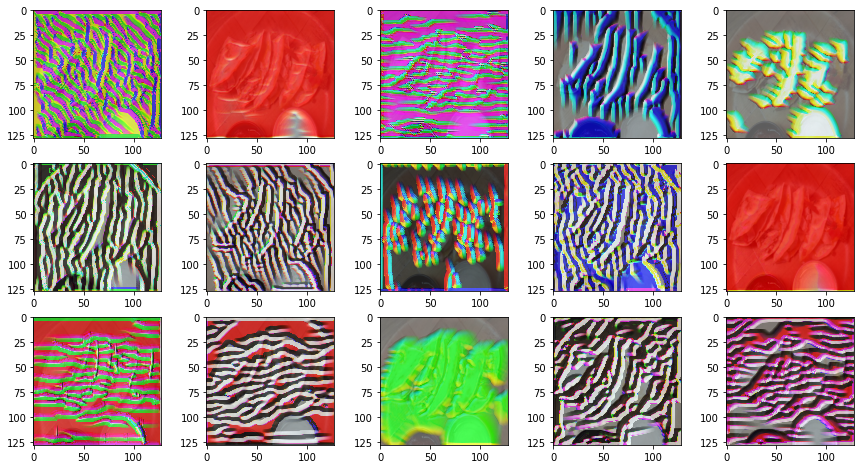

In [ ]:
fig, axs = plt.subplots(3, 5, figsize=(15, 8)) 
row = 0 
for i in range(1,16):
    # print(i,row)
    filter_activations, filter_visualization = filter_explaination(images, model_best, cnnid=2, filterid=i, iteration=100, lr=0.01)
    axs[row][(i%5)-1].imshow(normalize(filter_visualization.permute(1, 2, 0)))
    #plt.imshow(normalize(filter_visualization.permute(1, 2, 0)))
    #plt.show()
    if(i % 5 == 0 and i > 0):
        row += 1
plt.show()
plt.savefig(pic_name[pic_cnt])
pic_cnt += 1
plt.close()

In [ ]:
# 畫出 filter activations
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for i, img in enumerate(images):
    axs[0][i].imshow(img.permute(1, 2, 0))
for i, img in enumerate(filter_activations):
    axs[1][i].imshow(normalize(img))
plt.show()
plt.close()
# 從下面四張圖可以看到，activate 的區域對應到一些物品的邊界，尤其是顏色對比較深的邊界

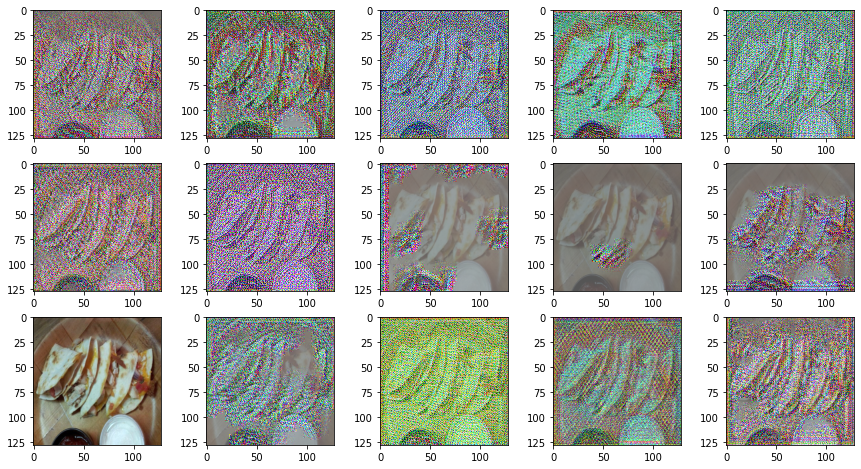

In [ ]:
img_indices = [83, 4218, 4707, 8598]
images, labels = train_set.getbatch(img_indices)
# filter_activations, filter_visualization = filter_explaination(images, model, cnnid=9, filterid=0, iteration=100, lr=0.1)


fig, axs = plt.subplots(3, 5, figsize=(15, 8)) 
row = 0 
for i in range(1,16):
    # print(i,row)
    filter_activations, filter_visualization = filter_explaination(images, model, cnnid=9, filterid=i, iteration=100, lr=0.01)
    axs[row][(i%5)-1].imshow(normalize(filter_visualization.permute(1, 2, 0)))
    #plt.imshow(normalize(filter_visualization.permute(1, 2, 0)))
    #plt.show()
    if(i % 5 == 0 and i > 0):
        row += 1
plt.savefig(pic_name[pic_cnt])
pic_cnt += 1
plt.show()
plt.close()

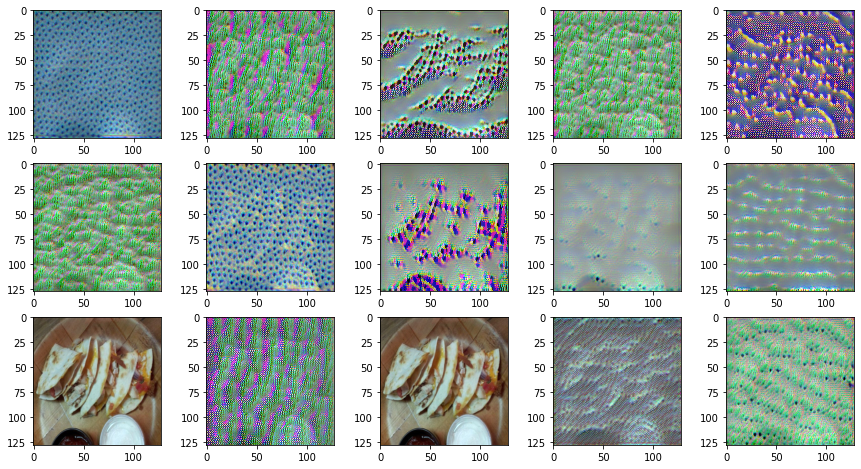

In [ ]:
fig, axs = plt.subplots(3, 5, figsize=(15, 8)) 
row = 0 
for i in range(1,16):
    # print(i,row)
    filter_activations, filter_visualization = filter_explaination(images, model, cnnid=17, filterid=i, iteration=100, lr=0.01)
    axs[row][(i%5)-1].imshow(normalize(filter_visualization.permute(1, 2, 0)))
    #plt.imshow(normalize(filter_visualization.permute(1, 2, 0)))
    #plt.show()
    if(i % 5 == 0 and i > 0):
        row += 1
plt.show()
plt.savefig(pic_name[pic_cnt])
pic_cnt += 1
plt.close()

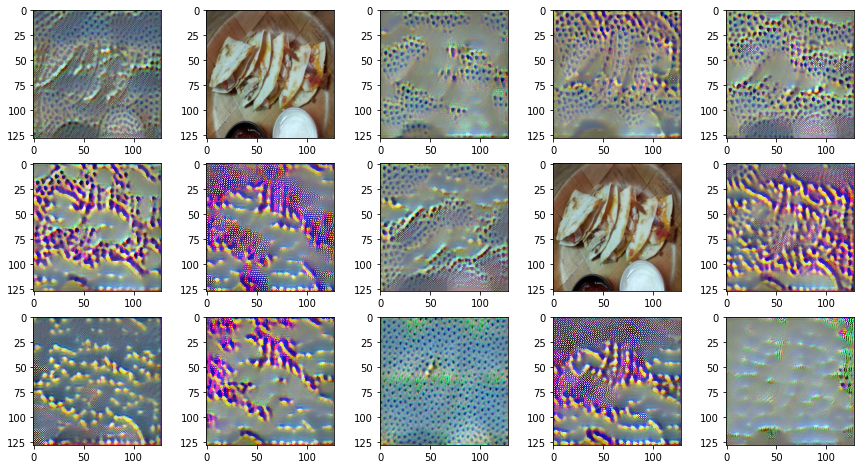

In [ ]:
fig, axs = plt.subplots(3, 5, figsize=(15, 8)) 
row = 0 
for i in range(1,16):
    # print(i,row)
    filter_activations, filter_visualization = filter_explaination(images, model, cnnid=25, filterid=i, iteration=100, lr=0.01)
    axs[row][(i%5)-1].imshow(normalize(filter_visualization.permute(1, 2, 0)))
    #plt.imshow(normalize(filter_visualization.permute(1, 2, 0)))
    #plt.show()
    if(i % 5 == 0 and i > 0):
        row += 1
plt.show()
plt.savefig(pic_name[pic_cnt])
pic_cnt += 1
plt.close()

## Lime

Lime 的部分因為有現成的套件可以使用，因此下方直接 demo 如何使用該套件。其實非常的簡單，只需要 implement 兩個 function 即可。

In [ ]:
def explain(instance, predict_fn, **kwargs):
  np.random.seed(0)
  return exp.explain_instance(instance, predict_fn, **kwargs)

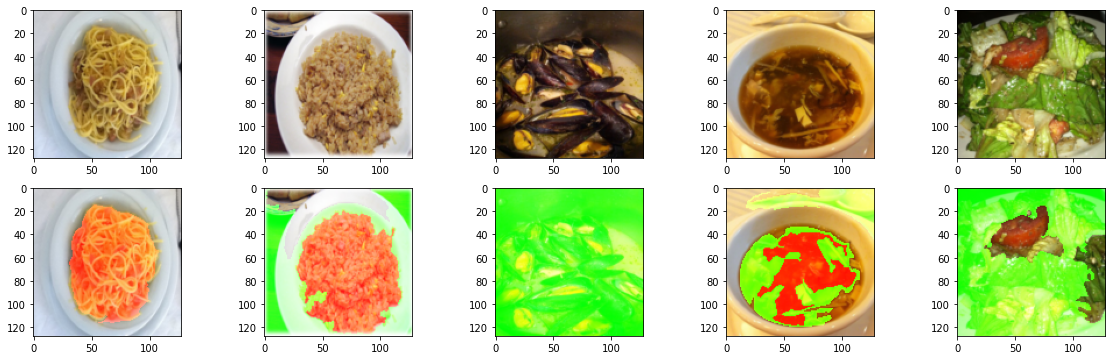

In [ ]:
np.random.seed(0)
def predict(input):
    # input: numpy array, (batches, height, width, channels)                                                                                                                                                     
    model.eval()                                                                                                                                                             
    input = torch.FloatTensor(input).permute(0, 3, 1, 2)                                                                                                            
    # 需要先將 input 轉成 pytorch tensor，且符合 pytorch 習慣的 dimension 定義
    # 也就是 (batches, channels, height, width)

    output = model(input.cuda())                                                                                                                                             
    return output.detach().cpu().numpy()                                                                                                                              
                                                                                                                                                                             
def segmentation(input):
    # 利用 skimage 提供的 segmentation 將圖片分成 100 塊                                                                                                                                      
    return slic(input, n_segments=10, compactness=1, sigma=1)                                                                                                              
                                                                                                                                                                             
img_indices = [7100 ,7300, 7700, 8598, 1236]
images, labels = train_set.getbatch(img_indices)
fig, axs = plt.subplots(2, len(img_indices), figsize=(20, 6))                                                                                                                                                                 
np.random.seed(0)                                                                                                                                                       
# 讓實驗 reproducible
for idx, (image, label) in enumerate(zip(images.permute(0, 2, 3, 1).numpy(), labels)):                                                                                                                                             
    x = image.astype(np.double)
    # lime 這個套件要吃 numpy array
    #print(x, predict)
    np.random.seed(16)  
    explainer = lime_image.LimeImageExplainer()                                                                                                                              
    explaination = explainer.explain_instance(image=x, classifier_fn=predict, segmentation_fn=segmentation, top_labels=11)
    # 基本上只要提供給 lime explainer 兩個關鍵的 function，事情就結束了
    # classifier_fn 定義圖片如何經過 model 得到 prediction
    # segmentation_fn 定義如何把圖片做 segmentation
    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=explain_instance#lime.lime_image.LimeImageExplainer.explain_instance

    lime_img, mask = explaination.get_image_and_mask(                                                                                                                         
                                label=label.item(),                                                                                                                           
                                positive_only=False,                                                                                                                         
                                hide_rest=False,                                                                                                                             
                                num_features=11,                                                                                                                              
                                min_weight=0.05                                                                                                                              
                            )
    # 把 explainer 解釋的結果轉成圖片
    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=get_image_and_mask#lime.lime_image.ImageExplanation.get_image_and_mask
    axs[0][idx].imshow(image)
    axs[1][idx].imshow(lime_img)
plt.savefig(pic_name[pic_cnt])
pic_cnt+=1
plt.show()
plt.close()
# 從以下前三章圖可以看到，model 有認出食物的位置，並以該位置為主要的判斷依據
# 唯一例外是第四張圖，看起來 model 似乎比較喜歡直接去認「碗」的形狀，來判斷該圖中屬於 soup 這個 class
# 至於碗中的內容物被標成紅色，代表「單看碗中」的東西反而有礙辨認。
# 當 model 只看碗中黃色的一坨圓形，而沒看到「碗」時，可能就會覺得是其他黃色圓形的食物。

# Deep Dream Visualization

source:      
1. https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html      
2. https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/src/deep_dream.py


In [14]:
import copy
from torch.autograd import Variable

def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """

    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0) # expand_dims(a, axis) 就是在 axis 的軸上把數據 a 加上去

    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
        # repeat函數功能：對數組中的元素進行連續重複複製
        # 用法有兩種：
        # 1) numpy.repeat(a, repeats, axis=None)
        # 2) a.repeats(repeats, axis=None)
        # 其中a為數組，repeats為重複的次數，axis表示數組維度

    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
        
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr

def save_image(im, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    im.save(path)

def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im

In [ ]:
from torch.optim import SGD
from torchvision import models
class DeepDream():
    """
        Produces an image that minimizes the loss of a convolution
        operation for a specific layer and filter
    """
    def __init__(self, model, selected_layer, selected_filter, im_path):
        self.model = model
        self.model.eval()
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0
        # Generate a random image
        self.created_image = Image.open(im_path).convert('RGB')
        # Hook the layers to get result of the convolution
        self.hook_layer()
        # Create the folder to export images if not exists
        if not os.path.exists('../generated'):
            os.makedirs('../generated')

    def hook_layer(self):
        def hook_function(module, grad_in, grad_out):
            # Gets the conv output of the selected filter (from selected layer)
            self.conv_output = grad_out[0, self.selected_filter]

        # Hook the selected layer
        self.model[self.selected_layer].register_forward_hook(hook_function)

    def dream(self):
        # Process image and return variable
        self.processed_image = preprocess_image(self.created_image, True)
        # Define optimizer for the image
        # Earlier layers need higher learning rates to visualize whereas layer layers need less
        optimizer = SGD([self.processed_image], lr=12,  weight_decay=1e-4)
        for i in range(1, 101):
            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = self.processed_image
            for index, layer in enumerate(self.model):
                # Forward
                x = layer(x)
                # Only need to forward until we the selected layer is reached
                if index == self.selected_layer:
                    break
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data.numpy()))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(self.processed_image)
            # Save image every 20 iteration
            if i % 10 == 0:
                print(self.created_image.shape)
                im_path = '../generated/ddream_l' + str(self.selected_layer) + \
                    '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg'
                save_image(self.created_image, im_path)


if __name__ == '__main__':
    # THIS OPERATION IS MEMORY HUNGRY! #
    # Because of the selected image is very large
    # If it gives out of memory error or locks the computer
    # Try it with a smaller image
    cnn_layer = 24
    filter_pos = 94

    im_path = '0.jpg'
    # Fully connected layer is not needed
    pretrained_model = models.vgg19(pretrained=True).features
    dd = DeepDream(models, cnn_layer, filter_pos, im_path)
    # This operation can also be done without Pytorch hooks
    # See layer visualisation for the implementation without hooks
    dd.dream()

## Reproduce Confusion Matrix

獲取檔案的 nparray 資料

In [ ]:
!gdown --id '1-T3KJeY5XN94NHsdya0vH4xJX1TTQt14' --output train_x.npy 
!gdown --id '1-VRyaY86OXEsFGRJnk0A9MstsMB80V1b' --output train_y.npy 
!gdown --id '1-UK5Wjt5VSnbS4GxrTnpvDjMIdKk6znY' --output val_x.npy 
!gdown --id '1-jhA40ps45c6QfpqLK7h1QiLZeAVV4iA' --output val_y.npy 
!gdown --id '1-cKSghWRnFGnq2-tSPmnC8YwAwUfU1ik' --output test_x.npy 
train_x = np.load('train_x.npy')
train_y = np.load('train_y.npy')
val_x = np.load('val_x.npy')
val_y = np.load('val_y.npy')
test_x = np.load('test_x.npy')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# training 時做 data augmentation
# Data augmentation原理
# 一張圖片經過旋轉、調整大小、比例尺寸，或者改變亮度色溫、翻轉等處理後，我們人眼仍能辨識出來是相同的相片，但是對機器來說那可是完全不同的新圖像了，
# 因此， Data augmentation就是將dataset中既有的圖片予以修改變形，以創造出更多的圖片來讓機器學習，彌補資料量不足的困擾。
train_transform = transforms.Compose([
    transforms.ToPILImage(), #轉成 python 圖片
    transforms.RandomHorizontalFlip(), # 隨機將圖片水平翻轉
    transforms.RandomRotation(15), # 隨機旋轉圖片，表示在（-15，+15）之间随机旋转
    transforms.ToTensor(), # 將圖片轉成 Tensor，並把數值 normalize 到 [0,1] (data normalization) ps. Tensor 為多維張量
    # transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5)) # 歸一化到 [-1, 1]
])
# testing 時不需做 data augmentation
test_transform = transforms.Compose([
    transforms.ToPILImage(),                                    
    transforms.ToTensor(),
])
class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
    # def __init__(self, x, y=None, transform=True):
        self.x = x
        # label is required to be a LongTensor
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

In [ ]:
batch_size = 128
train_set = ImgDataset(train_x, train_y, train_transform)
val_set = ImgDataset(val_x, val_y, test_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [ ]:
import time
model = Classifier().cuda()
loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # optimizer 使用 Adam
num_epoch = 120

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(train_loader):
        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        train_pred = model(data[0].cuda()) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數
        batch_loss = loss(train_pred, data[1].cuda()) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()
    
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            val_pred = model(data[0].cuda())
            batch_loss = loss(val_pred, data[1].cuda())

            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            val_loss += batch_loss.item()

        #將結果 print 出來
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/val_set.__len__(), val_loss/val_set.__len__()))

In [ ]:
from sklearn.metrics import classification_report
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.figure(figsize=(12, 8)) #fix_size
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
model.eval()
prediction = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        val_pred = model(data[0].cuda())
        val_label = np.argmax(val_pred.cpu().data.numpy(), axis=1)
        for y in val_label:
            prediction.append(y)
target_names = [ 'Bread','Dairy product' ,'Dessert','Egg', 'Fried food', 'Meat',
                'Noodles/Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable/Fruit']
plt.figure(1)
cm = confusion_matrix(val_y, prediction)
plot_confusion_matrix(cm, classes=target_names,normalize=True,
                    title='confusion matrix')

plt.show()